# Flow matching


### Reference :
- ***Github***:
    - https://github.com/CodingVillainKor/SimpleDeepLearning/blob/main/flowmatching.ipynb


In [1]:
import torch
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision import transforms

from random import random
from cv2 import imwrite
import math
import os
from pathlib import Path

In [2]:
import torch

if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
    !nvidia-smi
else:
    device = "cpu"

print(f"Available device : {device}")

Sun Sep 14 08:38:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.57.08              Driver Version: 575.57.08      CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     On  |   00000000:01:00.0  On |                  N/A |
| 60%   55C    P5             41W /  250W |    1060MiB /  11264MiB |     27%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:

dataset = MNIST(
    root="./temp/data", train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=128, shuffle=True, num_workers=4
)

In [4]:
def train(model, x, label):
    t = random()
    eps = torch.randn_like(x) # eps ~ N(0, I)
    x_t = t * x + (1-t) * eps
    drop_label = random() < 0.3
    hat = model(x_t, t, label, drop_label)
    loss = F.mse_loss(hat, x-eps)
    return loss

def write(x_0):
    x_0 = x_0.permute(0, 2, 3, 1).clamp(0, 1).detach().cpu().numpy() * 255
    imwrite("temp.png", x_0[0])

def sample(model, z, label, num_step=10, w=2.0, cfg=True):
    x_t = z # ~ N(0, I)
    ts = torch.linspace(0, 1, num_step+1) # num_step = 10 -> ts : [.0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 10]
    dts = ts[1:] - ts[:-1] # [.1,] * 10
    for t, dt in zip(ts[:-1], dts): # [.0, .1], [.1, .1], [.2, .1], ..., [.9, .1]
        hat = model(x_t, t, label, drop_label=False)
        if cfg:
            hat_uncond = model(x_t, t, label, drop_label=True)
            hat = (1+w) * hat - w * hat_uncond
        x_t = x_t + dt * hat
    return x_t

In [5]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class TimeEmbedding(nn.Module):
    def __init__(self, T, d_model, dim):
        assert d_model % 2 == 0
        super().__init__()
        emb = torch.arange(0, d_model, step=2) / d_model * math.log(10000)
        emb = torch.exp(-emb)
        pos = torch.arange(T).float()
        emb = pos[:, None] * emb[None, :]
        emb = torch.stack([torch.sin(emb), torch.cos(emb)], dim=-1)
        emb = emb.view(T, d_model)

        self.timembedding = nn.Sequential(
            nn.Linear(1, d_model),
            nn.Linear(d_model, dim),
            Swish(),
            nn.Linear(dim, dim),
        )
        self.initialize()

    def initialize(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                init.xavier_uniform_(module.weight)
                init.zeros_(module.bias)

    def forward(self, t):
        emb = self.timembedding(t)
        return emb

class DownSample(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.main = nn.Conv2d(in_ch, in_ch, 3, stride=2, padding=1)
        self.initialize()

    def initialize(self):
        init.xavier_uniform_(self.main.weight)
        init.zeros_(self.main.bias)

    def forward(self, x, temb):
        x = self.main(x)
        return x

class UpSample(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.main = nn.Conv2d(in_ch, in_ch, 3, stride=1, padding=1)
        self.initialize()

    def initialize(self):
        init.xavier_uniform_(self.main.weight)
        init.zeros_(self.main.bias)

    def forward(self, x, temb):
        _, _, H, W = x.shape
        x = F.interpolate(
            x, scale_factor=2, mode='nearest')
        x = self.main(x)
        return x

class AttnBlock(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.group_norm = nn.GroupNorm(32, in_ch)
        self.proj_q = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.proj_k = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.proj_v = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.proj = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.initialize()

    def initialize(self):
        for module in [self.proj_q, self.proj_k, self.proj_v, self.proj]:
            init.xavier_uniform_(module.weight)
            init.zeros_(module.bias)
        init.xavier_uniform_(self.proj.weight, gain=1e-5)

    def forward(self, x):
        B, C, H, W = x.shape
        h = self.group_norm(x)
        q = self.proj_q(h)
        k = self.proj_k(h)
        v = self.proj_v(h)

        q = q.permute(0, 2, 3, 1).view(B, H * W, C)
        k = k.view(B, C, H * W)
        w = torch.bmm(q, k) * (int(C) ** (-0.5))
        assert list(w.shape) == [B, H * W, H * W]
        w = F.softmax(w, dim=-1)

        v = v.permute(0, 2, 3, 1).view(B, H * W, C)
        h = torch.bmm(w, v)
        assert list(h.shape) == [B, H * W, C]
        h = h.view(B, H, W, C).permute(0, 3, 1, 2)
        h = self.proj(h)

        return x + h

class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, tdim, dropout, attn=False):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.GroupNorm(32, in_ch),
            Swish(),
            nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1),
        )
        self.temb_proj = nn.Sequential(
            Swish(),
            nn.Linear(tdim, out_ch),
        )
        self.block2 = nn.Sequential(
            nn.GroupNorm(32, out_ch),
            Swish(),
            nn.Dropout(dropout),
            nn.Conv2d(out_ch, out_ch, 3, stride=1, padding=1),
        )
        if in_ch != out_ch:
            self.shortcut = nn.Conv2d(in_ch, out_ch, 1, stride=1, padding=0)
        else:
            self.shortcut = nn.Identity()
        if attn:
            self.attn = AttnBlock(out_ch)
        else:
            self.attn = nn.Identity()
        self.initialize()

    def initialize(self):
        for module in self.modules():
            if isinstance(module, (nn.Conv2d, nn.Linear)):
                init.xavier_uniform_(module.weight)
                init.zeros_(module.bias)
        init.xavier_uniform_(self.block2[-1].weight, gain=1e-5)

    def forward(self, x, temb):
        h = self.block1(x)
        h += self.temb_proj(temb)[:, :, None, None]
        h = self.block2(h)

        h = h + self.shortcut(x)
        h = self.attn(h)
        return h

class UNet(nn.Module):
    def __init__(self, T, ch, ch_mult, attn, num_res_blocks, dropout):
        super().__init__()
        assert all([i < len(ch_mult) for i in attn]), 'attn index out of bound'
        tdim = ch * 4
        self.time_embedding = TimeEmbedding(T, ch, tdim)
        self.label_embedding = nn.Embedding(10, tdim)

        self.head = nn.Conv2d(1, ch, kernel_size=3, stride=1, padding=1)
        self.downblocks = nn.ModuleList()
        chs = [ch]  # record output channel when dowmsample for upsample
        now_ch = ch
        for i, mult in enumerate(ch_mult):
            out_ch = ch * mult
            for _ in range(num_res_blocks):
                self.downblocks.append(ResBlock(
                    in_ch=now_ch, out_ch=out_ch, tdim=tdim,
                    dropout=dropout, attn=(i in attn)))
                now_ch = out_ch
                chs.append(now_ch)
            if i != len(ch_mult) - 1:
                self.downblocks.append(DownSample(now_ch))
                chs.append(now_ch)

        self.middleblocks = nn.ModuleList([
            ResBlock(now_ch, now_ch, tdim, dropout, attn=True),
            ResBlock(now_ch, now_ch, tdim, dropout, attn=False),
        ])

        self.upblocks = nn.ModuleList()
        for i, mult in reversed(list(enumerate(ch_mult))):
            out_ch = ch * mult
            for _ in range(num_res_blocks + 1):
                self.upblocks.append(ResBlock(
                    in_ch=chs.pop() + now_ch, out_ch=out_ch, tdim=tdim,
                    dropout=dropout, attn=(i in attn)))
                now_ch = out_ch
            if i != 0:
                self.upblocks.append(UpSample(now_ch))
        assert len(chs) == 0

        self.tail = nn.Sequential(
            nn.GroupNorm(32, now_ch),
            Swish(),
            nn.Conv2d(now_ch, 1, 3, stride=1, padding=1)
        )
        self.initialize()

    def initialize(self):
        init.xavier_uniform_(self.head.weight)
        init.zeros_(self.head.bias)
        init.xavier_uniform_(self.tail[-1].weight, gain=1e-5)
        init.zeros_(self.tail[-1].bias)

    def forward(self, x, t, label, drop_label):
        # Timestep embedding
        t = torch.tensor([t], device=x.device)
        temb = self.time_embedding(t)
        lemb = self.label_embedding(label)
        if drop_label: lemb = torch.zeros_like(lemb)
        temb = temb + lemb
        # Downsampling
        h = self.head(x)
        hs = [h]
        for layer in self.downblocks:
            h = layer(h, temb)
            hs.append(h)
        # Middle
        for layer in self.middleblocks:
            h = layer(h, temb)
        # Upsampling
        for layer in self.upblocks:
            if isinstance(layer, ResBlock):
                h = torch.cat([h, hs.pop()], dim=1)
            h = layer(h, temb)
        h = self.tail(h)

        assert len(hs) == 0
        return h

In [6]:
model = UNet(T=1, ch=128, ch_mult=[2, 2], attn=[1],
             num_res_blocks=2, dropout=0.1).to(device)
optim = torch.optim.Adam(model.parameters(), lr=2e-4)

In [7]:
Path("./temp/cfm/eval").mkdir(exist_ok=True, parents=True)
Path("./temp/cfm/model").mkdir(exist_ok=True, parents=True)
for e in range(1, 10+1):
    model.train()
    for i, (x, l) in enumerate(dataloader, 1):
        optim.zero_grad()
        x, l = x.to(device), l.to(device)
        loss = train(model, x, l)
        loss.backward()
        optim.step()
        print("\r[Epoch: {} , Iter: {}/{}]  Loss: {:.3f}".format(e, i, len(dataloader), loss.item()), end='')
    print("\n> Eval at epoch {}".format(e))
    model_path = f"./temp/cfm/model/u_net_{e:02d}.pt"
    torch.save(model, model_path)
    model.eval()
    with torch.no_grad():
        # os.makedirs("./temp/cfm", exist_ok=True)
        x_T = torch.randn(1, 1, 28, 28).to(device)
        labels = [torch.zeros([1], device=device, dtype=torch.long) +  i for i in range(10)]
        for i in range(10):
            x_0 = sample(model, x_T, labels[i])
            x_0 = x_0.permute(0, 2, 3, 1).clamp(0, 1).detach().cpu().numpy() * 255
            imwrite(f"./temp/cfm/eval/gen_cfg_{e}_{i}.png", x_0[0])

[Epoch: 1 , Iter: 469/469]  Loss: 0.147
> Eval at epoch 1


[ WARN:0@254.741] global loadsave.cpp:1063 imwrite_ Unsupported depth image for selected encoder is fallbacked to CV_8U.


[Epoch: 2 , Iter: 469/469]  Loss: 0.139
> Eval at epoch 2
[Epoch: 3 , Iter: 469/469]  Loss: 0.220
> Eval at epoch 3
[Epoch: 4 , Iter: 469/469]  Loss: 0.105
> Eval at epoch 4
[Epoch: 5 , Iter: 469/469]  Loss: 0.091
> Eval at epoch 5
[Epoch: 6 , Iter: 469/469]  Loss: 0.097
> Eval at epoch 6
[Epoch: 7 , Iter: 469/469]  Loss: 0.084
> Eval at epoch 7
[Epoch: 8 , Iter: 469/469]  Loss: 0.105
> Eval at epoch 8
[Epoch: 9 , Iter: 469/469]  Loss: 0.097
> Eval at epoch 9
[Epoch: 10 , Iter: 469/469]  Loss: 0.089
> Eval at epoch 10


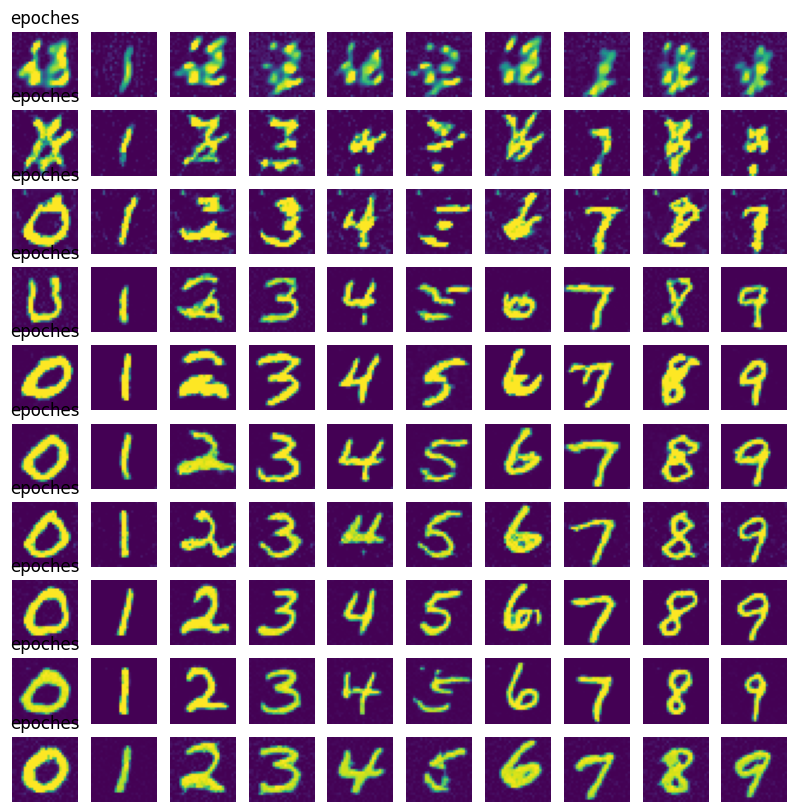

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

fig, axs = plt.subplots(10, 10, figsize = (10, 10))
for e in range(10):
    for i in range(10):
        fp = f"./temp/cfm/eval/gen_cfg_{e+1}_{i}.png"
        img = Image.open(fp)
        axs[e, i].imshow(img)
        axs[e, i].axis('off')

plt.show()

